In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

from hyperparameters import *

import pickle

# Lead Data

In [2]:
# Loading data
train_features = pd.read_parquet("generated-data/preprocessed-data/train_features.parquet")
val_features = pd.read_parquet("generated-data/preprocessed-data/val_features.parquet")
test_features = pd.read_parquet("generated-data/preprocessed-data/test_features.parquet")

train_labels = pd.read_parquet("generated-data/preprocessed-data/train_labels.parquet")
val_labels = pd.read_parquet("generated-data/preprocessed-data/val_labels.parquet")
test_labels = pd.read_parquet("generated-data/preprocessed-data/test_labels.parquet")

# Output results
print("train_features: \n", train_features.head())
print("val_features: \n", val_features.head())
print("test_features: \n", test_features.head())
print("train_labels: \n", train_labels.head())
print("val_labels: \n", val_labels.head())
print("test_labels: \n", test_labels.head())

train_features: 
          x0        x1        x2        x3        x4        x5        x6  \
0  0.434685  0.429033  0.412056  0.416066  0.395883  0.425452  0.384255   
1  0.359876  0.464111  0.523374  0.602705  0.620481  0.487745  0.512668   
2  0.454485  0.535816  0.625902  0.691476  0.613283  0.645376  0.643182   
3  0.274160  0.312420  0.330597  0.387822  0.393462  0.288355  0.345268   
4  0.390677  0.426325  0.445977  0.498583  0.511005  0.403761  0.414614   

         x7        x8        x9  ...       z11       z12       z13       z14  \
0  0.366576  0.379328  0.428028  ...  0.786917  0.811788  0.806893  0.793212   
1  0.565325  0.611464  0.475684  ...  0.832133  0.832647  0.810738  0.792895   
2  0.650025  0.662246  0.599285  ...  0.706600  0.708544  0.769945  0.747259   
3  0.393389  0.435578  0.293838  ...  0.808719  0.840839  0.793781  0.797308   
4  0.424334  0.451496  0.404609  ...  0.831265  0.853745  0.811296  0.806500   

        z15       z16       z17       z18       z1

# Create Dataloaders

In [3]:
# Defining dataset
class HandLandmarksDataset(Dataset):

    def __init__(self, data, labels):

        # Initializing data and labels
        self.data = data.astype('float32')
        self.labels = labels
    

    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):

        features = self.data.iloc[idx].values
        label = self.labels.iloc[idx].values.squeeze()

        return features, label


In [4]:
# Creating Datasets
train_dataset = HandLandmarksDataset(train_features, train_labels)
val_dataset = HandLandmarksDataset(val_features, val_labels)
test_dataset = HandLandmarksDataset(test_features, test_labels)

In [5]:
# Creating Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Defining the Neural Network

Network architecture is store in `architecture.py`

In [6]:
from architecture import FullyDenseNetwork

# Define Model Training and Testing

In [7]:
# Used for holding stats
stats_col_names = ["epoch", "train_loss", "train_acc", "val_loss", "val_acc"]
stats = []

In [8]:
# Evaluation function
def evaluate_model(model, loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy


In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, device='cpu'):
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            
            # Loss calculation
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update running loss and accuracy
            running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        stats.append([epoch+1, epoch_loss, epoch_acc, val_loss, val_acc])
        
        print(f'Epoch {epoch+1: >3}/{epochs}, Train Loss: {epoch_loss:>6.4f}, Train Accuracy: {epoch_acc:>6.4f}, Val Loss: {val_loss:>6.4f}, Val Accuracy: {val_acc:>6.4f}')

In [10]:
def test_model(model, test_loader, criterion, device='cpu'):
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


# Initialize Training

In [11]:
model = FullyDenseNetwork(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS)

criterion = LOSS_FUNCTION
optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE)

# Train Model

In [12]:
# Training the model
train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

# Testing the model
test_model(model, test_loader, criterion)

Epoch   1/200, Train Loss: 3.1331, Train Accuracy: 0.0949, Val Loss: 3.0481, Val Accuracy: 0.1427
Epoch   2/200, Train Loss: 2.8101, Train Accuracy: 0.1733, Val Loss: 2.4882, Val Accuracy: 0.2315
Epoch   3/200, Train Loss: 2.1583, Train Accuracy: 0.3534, Val Loss: 1.9181, Val Accuracy: 0.3895
Epoch   4/200, Train Loss: 1.7009, Train Accuracy: 0.5067, Val Loss: 1.5566, Val Accuracy: 0.5637
Epoch   5/200, Train Loss: 1.4249, Train Accuracy: 0.5902, Val Loss: 1.3823, Val Accuracy: 0.5798
Epoch   6/200, Train Loss: 1.2449, Train Accuracy: 0.6431, Val Loss: 1.1802, Val Accuracy: 0.6637
Epoch   7/200, Train Loss: 1.1113, Train Accuracy: 0.6875, Val Loss: 1.0723, Val Accuracy: 0.6863
Epoch   8/200, Train Loss: 1.0105, Train Accuracy: 0.7100, Val Loss: 0.9655, Val Accuracy: 0.7347
Epoch   9/200, Train Loss: 0.9349, Train Accuracy: 0.7311, Val Loss: 0.8983, Val Accuracy: 0.7395
Epoch  10/200, Train Loss: 0.8830, Train Accuracy: 0.7430, Val Loss: 0.8429, Val Accuracy: 0.7452
Epoch  11/200, Train

# Evaluation

In [13]:
stats_df = DataFrame(stats, columns=stats_col_names)
stats_df.head()

,epoch,train_loss,train_acc,val_loss,val_acc
0,1,3.133125,0.094884,3.048123,0.142742
1,2,2.810061,0.173349,2.488204,0.231452
2,3,2.158251,0.353439,1.918141,0.389516
3,4,1.700934,0.506740,1.556575,0.563710
4,5,1.424904,0.590218,1.382311,0.579839


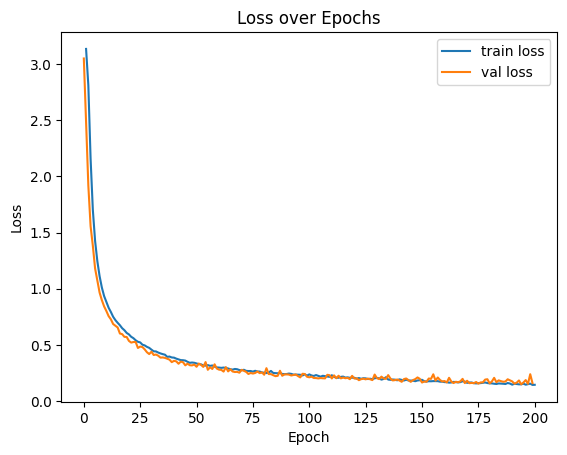

In [14]:
# Plot loss graph
plt.plot(stats_df['epoch'], stats_df['train_loss'], stats_df['val_loss'])

# Label plot
plt.title("Loss over Epochs")
plt.legend(["train loss", "val loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show plot
plt.show()

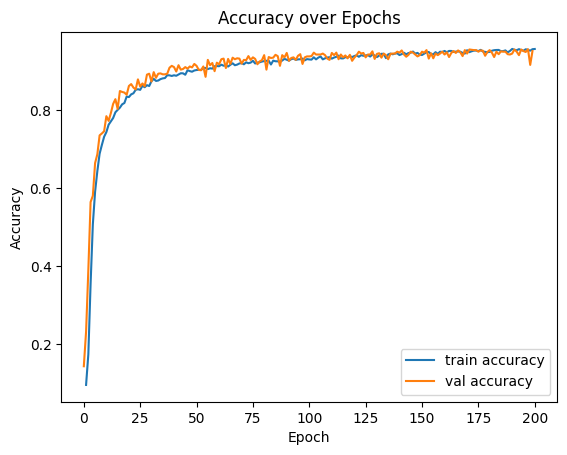

In [15]:
# Plot accuracy
plt.plot(stats_df['epoch'], stats_df['train_acc'], stats_df['val_acc'])

# Label plot
plt.title("Accuracy over Epochs")
plt.legend(["train accuracy", "val accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Show plot
plt.show()

# Saving Model

In [16]:
# Saving Model as pickle
with open('generated-data/model/model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
# cpu_seed = torch.initial_seed()
# cpu_seed
# 12521691143669667420

12521691143669667420